In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# import findspark
# findspark.init()

In [3]:
# import pyspark
# from pyspark.sql import functions

In [4]:
# sc = pyspark.SparkContext(appName="bootstrap")

In [5]:
# sqlCtx = pyspark.SQLContext(sc)

In [5]:
# @user credentials

user='leon.zhao@offerupnow.com'
password='Steel24ly@offerup'
account='offerup'

In [6]:
import snowflake.connector

class SnowflakeSession:

    def __init__(self, user, password, account):

        # Connect and get cursor
        print("> Connecting to Snowflake")
        self.ctx = snowflake.connector.connect(user=user,
                                                password=password,
                                                account=account, )
        self.cs = self.ctx.cursor()

        # Set up cursor
        self.cs.execute("use warehouse analytics_wh;")
        self.cs.execute("use role marketing;")
        self.cs.execute("Alter session set timezone = 'America/Los_Angeles';") # for TZ aware fields

    @staticmethod
    def parse_query_file(sql_query_file):
        """Parse SQL file and return query as string."""
        
        # Reading of the SQL statement from sql_query.txt file
        print("> Reading SQL statement from file")
        fd = open(sql_query_file, 'r')
        sqlFile = fd.read()
        fd.close()

        # Extraction of the SQL statement (split on ';')
        # Get only the first statement.
        sql_sentence_list = sqlFile.split(';')
        sql_query = [x for x in sql_sentence_list if x][0]

        return sql_query

    def execute_query(self, qry):
        print("> Querying database with:")
        print(qry)
        print("\n> Fetching data ...")
        self.cs.execute(qry)
        colnames = [x[0] for x in self.cs.description]
        rows = self.cs.fetchall()
        return rows, colnames

    @staticmethod
    def result_to_df(rows, colnames):
        print("> Saving to dataframe ...")
        df =  pd.DataFrame(rows, columns=colnames)
        df.replace({r'\r': ''}, regex=True, inplace=True)
        return df


    @staticmethod
    def save_df_to_csv(df, fname):
        print("\n> Saving to file ...")
        if '.csv' in fname:
            separator = ','
        else:
            separator = '\t'
        df.to_csv(fname, index=False, sep=separator, header=True, encoding='utf-8')

    def close_session(self):
        print("\n> Closing session ...")
        self.cs.close()
        self.ctx.close()
        
s = SnowflakeSession(user, password, account)

> Connecting to Snowflake


# Adjust Dataset for bootstrap

In [7]:
data = s.parse_query_file('/Users/leon.zhao/Desktop/SQL/simplification_test_summary')
# data = s.parse_query_file('/Users/leon.zhao/Desktop/SQL/simplification_test_summary_no_outliers')
print(data)
rows, colnames = s.execute_query(data)

> Reading SQL statement from file
select *
from ou_users.leon.sa_simplification_summary

> Querying database with:
select *
from ou_users.leon.sa_simplification_summary


> Fetching data ...


In [8]:
df = pd.DataFrame(data = rows, columns = colnames)
df.head()

,PLAT,USER_ID,VARIANT_ID,FIRST_EXPOSURE_TS,VARIANT_NAME,BUMP_REVENUE,PROMOTION_REVENUE,SUB_REVENUE,BUMPS,ITEM_PROMOTIONS,SUB_PURCHASES,SA_1D_REVENUE,SA_3D_REVENUE,SA_7D_REVENUE,SA_14D_REVENUE,PRICE_1DAY_PURCHASES,PRICE_3DAY_PURCHASES,PRICE_7DAY_PURCHASES,PRICE_14DAY_PURCHASES
0,AD,10729217,"""5123000743493632""",2019-03-11 04:16:35,Subs_1d_3d,0.0,0.00,0.0,0,0,0,0.00,0.0,0.0,0.0,0,0,0,0
1,AD,17608841,"""5123000743493632""",2019-02-11 03:23:04,Subs_1d_3d,0.0,11.96,0.0,0,4,0,11.96,0.0,0.0,0.0,4,0,0,0
2,AD,39547752,"""5123000743493632""",2019-03-09 12:36:46,Subs_1d_3d,0.0,0.00,0.0,0,0,0,0.00,0.0,0.0,0.0,0,0,0,0
3,AD,56563145,"""5123000743493632""",2019-03-09 18:20:26,Subs_1d_3d,0.0,0.00,0.0,0,0,0,0.00,0.0,0.0,0.0,0,0,0,0
4,AD,38966538,"""5123000743493632""",2019-02-26 23:55:47,Subs_1d_3d,0.0,0.00,0.0,0,0,0,0.00,0.0,0.0,0.0,0,0,0,0


In [6]:
platform = {}
rev_output = {}
for plat in ['AD','iOS']:
    df1 = df.loc[df['PLAT'] == plat]
    platform[plat] = df1
    rev_output[plat + '_rev'] = platform[plat].loc[:,['PLAT','VARIANT_NAME','BUMP_REVENUE','PROMOTION_REVENUE','SUB_REVENUE'] ]
    rev_output[plat + '_rev']['IAP_REVENUE'] = rev_output[plat + '_rev'].iloc[:,1:].sum(axis=1)
    rev_output[plat + '_rev_no_zeros'] = rev_output[plat + '_rev'][rev_output[plat + '_rev'].IAP_REVENUE != 0.0]


In [7]:
df_names = []
for key, value in rev_output.items() :
    df_names.append(key)
    
# df_names_no_zeros = ['AD_rev_no_zeros', 'iOS_rev_no_zeros']
# df_names, df_names_no_zeros

In [8]:
variant_dic = {}
for df in df_names:
    for variant_name in ['Control', 'Subs_1d_3d', 'Subs_bump_3d', 'Subs_1d_3d_7d_14d']:
        print(df+'_'+variant_name)
        print(rev_output[df][rev_output[df].VARIANT_NAME == variant_name].describe())
        variants = rev_output[df].loc[rev_output[df]['VARIANT_NAME'] == variant_name]
        variant_dic[df+'_'+variant_name+'_iap'] = variants.iloc[:,-1]
#         print(variants)

for key, value in variant_dic.items():
    iap = pd.DataFrame(value)
#     print(key, iap.describe())
#     print(key, iap.head(10))
    
# for key, value in variant_dic.items():
#     plt.hist(value, bins=np.arange(min(value)+1, max(value) + 1, 1), label=key, density = False)
#     plt.title(key)
#     plt.legend()
#     plt.show()


AD_rev_Control
       BUMP_REVENUE  PROMOTION_REVENUE   SUB_REVENUE   IAP_REVENUE
count  96812.000000       96812.000000  96812.000000  96812.000000
mean       0.166257           0.316903      0.235803      0.718964
std        1.993254           4.307652      2.158275      5.450383
min        0.000000           0.000000      0.000000      0.000000
25%        0.000000           0.000000      0.000000      0.000000
50%        0.000000           0.000000      0.000000      0.000000
75%        0.000000           0.000000      0.000000      0.000000
max      203.490000         579.710000     19.990000    579.710000
AD_rev_Subs_1d_3d
       BUMP_REVENUE  PROMOTION_REVENUE   SUB_REVENUE   IAP_REVENUE
count  96864.000000       96864.000000  96864.000000  96864.000000
mean       0.007338           0.372539      0.264156      0.644032
std        0.493311           4.612793      2.282707      5.339167
min        0.000000           0.000000      0.000000      0.000000
25%        0.000000          

In [9]:
variant_dic_nonzero = {}
for variant, value_series in variant_dic.items():
    values_non_zero = [v for v in value_series.values if v > 0]
    variant_dic_nonzero[variant] = np.array(values_non_zero)
    
variant_dic_nonzero.items()

dict_items([('AD_rev_Control_iap', array([13.93, 12.99,  7.96, ...,  7.98,  3.99, 23.97])), ('AD_rev_Subs_1d_3d_iap', array([19.99,  2.99, 19.99, ...,  7.99, 19.99,  7.99])), ('AD_rev_Subs_bump_3d_iap', array([ 1.99,  1.99,  7.99, ...,  7.99,  3.98, 19.99])), ('AD_rev_Subs_1d_3d_7d_14d_iap', array([ 5.98, 39.96,  2.99, ...,  7.99, 19.99,  2.99])), ('AD_rev_no_zeros_Control_iap', array([13.93, 12.99,  7.96, ...,  7.98,  3.99, 23.97])), ('AD_rev_no_zeros_Subs_1d_3d_iap', array([19.99,  2.99, 19.99, ...,  7.99, 19.99,  7.99])), ('AD_rev_no_zeros_Subs_bump_3d_iap', array([ 1.99,  1.99,  7.99, ...,  7.99,  3.98, 19.99])), ('AD_rev_no_zeros_Subs_1d_3d_7d_14d_iap', array([ 5.98, 39.96,  2.99, ...,  7.99, 19.99,  2.99])), ('iOS_rev_Control_iap', array([ 1.99, 19.99,  1.99, ...,  1.99,  1.99, 11.97])), ('iOS_rev_Subs_1d_3d_iap', array([19.99, 19.97,  2.99, ...,  7.99,  2.99, 10.98])), ('iOS_rev_Subs_bump_3d_iap', array([15.98,  7.99, 19.99, ...,  1.99,  1.99, 61.94])), ('iOS_rev_Subs_1d_3d_7d_1

# Getting 
1. Purchaser penetration
2. Number of Users Bucketed
3. Total IAP revenue within bucket

In [10]:
p = {}
proportion = [['AD_rev', 'AD_rev_no_zeros'],['iOS_rev', 'iOS_rev_no_zeros']]
variant_name = ['Control', 'Subs_1d_3d', 'Subs_bump_3d', 'Subs_1d_3d_7d_14d']
for i in range(len(proportion)):
    for v_name in variant_name:
        p_comb_n = proportion[i][1]+'_'+v_name
        p_comb_d = proportion[i][0]+'_'+v_name
        p[p_comb_d] = variant_dic[p_comb_n+'_iap'].count()/variant_dic[p_comb_d+'_iap'].count(), variant_dic[p_comb_d+'_iap'].count(), variant_dic[p_comb_d+'_iap'].sum()
    
p

{'AD_rev_Control': (0.05569557492872784, 96812, 69604.29999999999),
 'AD_rev_Subs_1d_3d': (0.04842872481004295, 96864, 62383.54000000001),
 'AD_rev_Subs_bump_3d': (0.05546079495529022, 96735, 69795.86),
 'AD_rev_Subs_1d_3d_7d_14d': (0.050389362935962224, 96568, 73373.09),
 'iOS_rev_Control': (0.08048340351069065, 182870, 192140.63999999998),
 'iOS_rev_Subs_1d_3d': (0.0753298658636737, 182650, 180144.12),
 'iOS_rev_Subs_bump_3d': (0.08079930495221546, 181858, 189215.11),
 'iOS_rev_Subs_1d_3d_7d_14d': (0.07422987671428728, 181854, 191365.31)}

# Sampling the data for num_iterations times
1. Simulating number of purchasers with binomial draws
2. Simulating value spent with random draws
3. Generate sim_final: values spent per purchaser

In [11]:
num_iterations = 10000
binomial = {}
revenue = {}
sim_final = {}
for variants, values in p.items():
    #print(int(values[1]))
    for i in range(num_iterations):
        binomial.setdefault(variants, []).append(np.random.binomial(values[1], values[0]))
        revenue.setdefault(variants, []).append(np.random.choice(variant_dic_nonzero[variants + '_iap'], size=binomial[variants][i], replace=True))
        sim_final.setdefault(variants, []).append(np.sum(revenue[variants][i]) / values[1])


In [15]:
sim_final[ad_variant_name[1]][1000]

0.6463829699372315

# Get differences for key metric variants vs. control

In [16]:
variant_name = []
for name in p.keys():
    variant_name.append(name)


ad_variant_name = variant_name[:len(variant_name)//2]
ios_variant_name = variant_name[len(variant_name)//2:]

ad_bootstrapped_diff = {}
ios_bootstrapped_diff = {}

for i in range(1,len(ad_variant_name)):
    for j in range(num_iterations):
        ad_bootstrapped_diff.setdefault(ad_variant_name[i], []).append(sim_final[ad_variant_name[i]][j] - sim_final[ad_variant_name[0]][j])

for i in range(1,len(ios_variant_name)):
    for j in range(num_iterations):
        ios_bootstrapped_diff.setdefault(ios_variant_name[i], []).append(sim_final[ios_variant_name[i]][j] - sim_final[ios_variant_name[0]][j])

# ad_bootstrapped_diff, ios_bootstrapped_diff

In [23]:
pd.DataFrame(ad_bootstrapped_diff['AD_rev_Subs_1d_3d']).describe()
# ios_bootstrapped_diff['iOS_rev_Subs_1d_3d'].describe()

,0
count,10000.000000
mean,-0.075382
std,0.024388
min,-0.164219
25%,-0.092003
50%,-0.075724
75%,-0.058976
max,0.019177


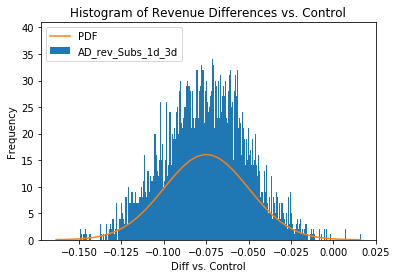

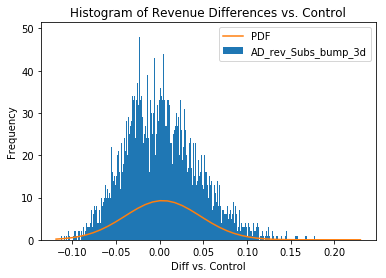

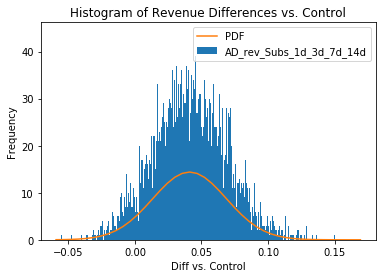

In [28]:
for key, value in ad_bootstrapped_diff.items():
    ad_bootstrapped_diff[key] = np.array(value)
    x=np.linspace(min(value), max(value), 42)
    mean=value.mean()
    std=value.std()
    y_pdf=stats.norm.pdf(x,mean,std)
    plt.hist(value, bins=1000, label=key, density = False)
    plt.plot(x,y_pdf, label='PDF')
    plt.title(key)
    plt.legend()
    plt.xlabel('Diff vs. Control')
    plt.ylabel('Frequency')
    plt.title(r'Histogram of Revenue Differences vs. Control')
    plt.show()



In [33]:
alpha=0.05
output = {}

for keys in ad_bootstrapped_diff.keys():
    val = np.percentile(ad_bootstrapped_diff[keys], 50)
    low = np.percentile(ad_bootstrapped_diff[keys], 100 * (alpha / 2.))
    high = np.percentile(ad_bootstrapped_diff[keys], 100 * (1 - alpha / 2.))
    print(keys)
    print('{}\t({}, {})'.format(val,low,high))
    print(min(2*np.sum(np.array(ad_bootstrapped_diff[keys]) < 0)/num_iterations,
              2*np.sum(np.array(ad_bootstrapped_diff[keys]) > 0)/num_iterations))

AD_rev_Subs_1d_3d
-0.07527160541295691	(-0.12288888058925067, -0.026781848463194764)
0.0024
AD_rev_Subs_bump_3d
-0.000737758488213669	(-0.06879258395833036, 0.0949348276128198)
0.9868
AD_rev_Subs_1d_3d_7d_14d
0.04056998520119903	(-0.012127596054937064, 0.09548208780543904)
0.1268


In [80]:
for keys in ios_bootstrapped_diff.keys():
    val = np.percentile(ios_bootstrapped_diff[keys], 50)
    low = np.percentile(ios_bootstrapped_diff[keys], 100 * (alpha / 2.))
    high = np.percentile(ios_bootstrapped_diff[keys], 100 * (1 - alpha / 2.))
    print(keys)
    print('{}\t({}, {})'.format(val,low,high))
    print(min(2*np.sum(np.array(ios_bootstrapped_diff[keys]) < 0)/num_iterations,
              2*np.sum(np.array(ios_bootstrapped_diff[keys]) > 0)/num_iterations))

iOS_rev_Subs_1d_3d
-0.06382884235720165	(-0.11391661596749868, -0.015059657172403583)
0.0092
iOS_rev_Subs_bump_3d
-0.00983462748871311	(-0.06365272845911286, 0.044320165629588765)
0.7186
iOS_rev_Subs_1d_3d_7d_14d
0.0022488450772901736	(-0.04897017388857124, 0.05176610905657555)
0.9276


In [81]:
AD_rev_Subs_1d_3d = np.array(ad_bootstrapped_diff['AD_rev_Subs_1d_3d'])
AD_rev_Subs_bump_3d = np.array(ad_bootstrapped_diff['AD_rev_Subs_bump_3d'])
AD_rev_Subs_1d_3d_7d_14d = np.array(ad_bootstrapped_diff['AD_rev_Subs_1d_3d_7d_14d'])
iOS_rev_Subs_1d_3d = np.array(ios_bootstrapped_diff['iOS_rev_Subs_1d_3d'])
iOS_rev_Subs_bump_3d = np.array(ios_bootstrapped_diff['iOS_rev_Subs_bump_3d'])
iOS_rev_Subs_1d_3d_7d_14d = np.array(ios_bootstrapped_diff['iOS_rev_Subs_1d_3d_7d_14d'])

ad_diff = np.concatenate((AD_rev_Subs_1d_3d, AD_rev_Subs_bump_3d, AD_rev_Subs_1d_3d_7d_14d),0)
gph = [AD_rev_Subs_1d_3d, AD_rev_Subs_bump_3d, AD_rev_Subs_1d_3d_7d_14d, iOS_rev_Subs_1d_3d, iOS_rev_Subs_bump_3d, iOS_rev_Subs_1d_3d_7d_14d]

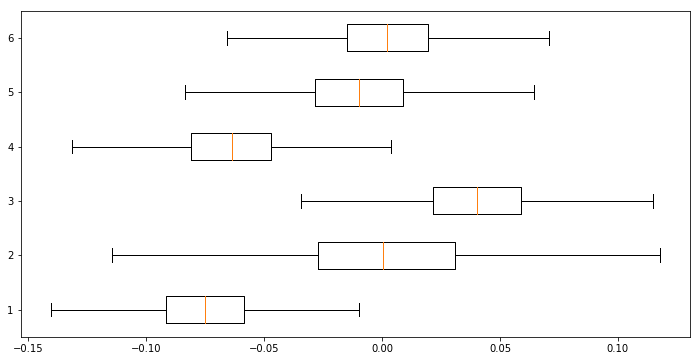

In [82]:
# multiple box plots on one figure
plt.figure(figsize=(12,6))
plt.boxplot(gph, showfliers=False, vert=False)
plt.show()

In [83]:
import seaborn as sns
sea_df_ad = pd.DataFrame.from_dict(ad_bootstrapped_diff)
sea_df_ad.head()

,AD_rev_Subs_1d_3d,AD_rev_Subs_bump_3d,AD_rev_Subs_1d_3d_7d_14d
0,-0.085654,0.004815,-0.007810
1,-0.069580,0.002631,-0.012930
2,-0.065843,-0.024381,0.008806
3,-0.124080,-0.059233,-0.010508
4,-0.071849,-0.060728,-0.008965


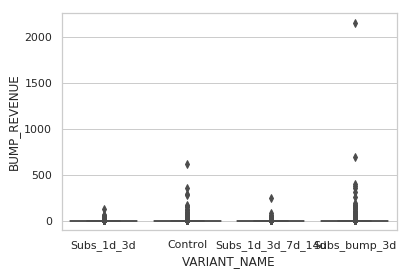

In [50]:
sns.set(style="whitegrid")
ax = sns.boxplot(x='VARIANT_NAME', y='BUMP_REVENUE',data=df)

# Archives

In [35]:
# from collections import defaultdict

# num_iterations = 10
# sim_final = defaultdict(list)
# for variant, values in p.items():
#     #print(int(values[1]))
#     for i in range(num_iterations):
#         n_non_zero = np.random.binomial(values[1], values[0])  
#         revenue = np.sum(np.random.choice(a=variant_dic_nonzero[variant + '_iap'], size=n_non_zero, replace=True))
#         sim_final[variant].append(revenue/values[1])

# sim_final

In [36]:
# bootstrapped_means_diff = np.array(sim_final['AD_rev_Control']) - np.array(sim_final['AD_rev_Subs_1d_3d'])
# alpha=0.05
# low = np.percentile(bootstrapped_means_diff, 100 * (alpha / 2.))
# val = np.percentile(bootstrapped_means_diff, 50)
# high = np.percentile(bootstrapped_means_diff, 100 * (1 - alpha / 2.))

# print(bootstrapped_means_diff.shape[0])
# # print(variant)
# print('{}\t({}, {})'.format(val,low,high))
# print('p-value: {}'.format(min(2*np.sum(bootstrapped_means_diff < 0)/bootstrapped_means_diff.shape[0],
#                                2*np.sum(bootstrapped_means_diff > 0)/bootstrapped_means_diff.shape[0])))

# print(bootstrapped_means_diff > 0)



In [ ]:
# for variant in p.keys():
#     bootstrapped_means_diff = np.array(sim_final[variant])
#     alpha=0.05
#     low = np.percentile(bootstrapped_means_diff, 100 * (alpha / 2.))
#     val = np.percentile(bootstrapped_means_diff, 50)
#     high = np.percentile(bootstrapped_means_diff, 100 * (1 - alpha / 2.))

#     # print(ctrl.describe(), test.describe())
#     print(variant)
#     print('{}\t({}, {})'.format(val,low,high))
#     print('\n')